In [1]:
# Импорт базовых библиотек
import numpy as np
import pandas as pd

# Визуализация

import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier

# Метрики
from sklearn.metrics import precision_score, recall_score, f1_score 

# Misc
from sklearn.manifold import TSNE

%matplotlib inline

Будем обрабатывать NBA 2k20 player dataset

In [2]:
df = pd.read_csv('nba2k-full.csv')
df.head(13)

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college,version
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN,NBA2k20
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State,NBA2k20
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN,NBA2k20
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas,NBA2k20
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State,NBA2k20
5,Stephen Curry,95,#30,Golden State Warriors,G,03/14/88,6-3 / 1.91,185 lbs. / 83.9 kg.,$40231758,USA,2009,1,7,Davidson,NBA2k20
6,Anthony Davis,94,#3,Los Angeles Lakers,F-C,03/11/93,6-10 / 2.08,222 lbs. / 100.7 kg.,$27093019,USA,2012,1,1,Kentucky,NBA2k20
7,Paul George,93,#13,Los Angeles Clippers,F,05/02/90,6-8 / 2.03,210 lbs. / 95.3 kg.,$33005556,USA,2010,1,10,Fresno State,NBA2k20
8,Damian Lillard,92,#0,Portland Trail Blazers,G,07/15/90,6-2 / 1.88,195 lbs. / 88.5 kg.,$29802321,USA,2012,1,6,Weber State,NBA2k20
9,Joel Embiid,91,#21,Philadelphia 76ers,C,03/16/94,7-0 / 2.13,250 lbs. / 113.4 kg.,$27504630,Cameroon,2014,1,3,Kansas,NBA2k20


## Предобработка

Будем предсказывать позицию игрока на поле по его росту, весу и номеру

In [3]:
df = df.drop(['full_name', 'rating', 'team', 'b_day', 'country', 'draft_round', 'draft_peak', 'college', 'version', 'salary', 'draft_year'], axis=1)
df.head()

,jersey,position,height,weight
0,#23,F,6-9 / 2.06,250 lbs. / 113.4 kg.
1,#2,F,6-7 / 2.01,225 lbs. / 102.1 kg.
2,#34,F-G,6-11 / 2.11,242 lbs. / 109.8 kg.
3,#7,F,6-10 / 2.08,230 lbs. / 104.3 kg.
4,#13,G,6-5 / 1.96,220 lbs. / 99.8 kg.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   jersey    439 non-null    object
 1   position  439 non-null    object
 2   height    439 non-null    object
 3   weight    439 non-null    object
dtypes: object(4)
memory usage: 13.8+ KB


Приведем признаки в надлежащий вид (рост, вес и номер приведем к численным значениям)

In [5]:
df['jersey'] = df['jersey'].map(lambda x: x.lstrip('#'))
df['jersey'] = df['jersey'].astype(int)
df['height'] = df['height'].str.split('/').str.get(1)
df['height'] = df['height'].astype(float)
df['weight'] = df['weight'].str.split('/').str.get(1)
df['weight'] = [x[:-3] for x in df['weight']]
df['weight'] = df['weight'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   jersey    439 non-null    int32  
 1   position  439 non-null    object 
 2   height    439 non-null    float64
 3   weight    439 non-null    float64
dtypes: float64(2), int32(1), object(1)
memory usage: 12.1+ KB


Получим информацию по базовым статистикам для каждого признака

In [6]:
df.describe()

,jersey,height,weight
count,439.000000,439.000000,439.000000
mean,14.733485,1.996264,97.326196
std,16.339284,0.083541,10.530609
min,0.000000,1.750000,77.100000
25%,2.000000,1.930000,89.400000
50%,10.000000,2.010000,97.100000
75%,22.000000,2.060000,104.300000
max,99.000000,2.240000,131.500000


Зададим явно целевой признак (y - позиция) и признаки, по которым будем предсказывать (X - рост, вес и номер)

In [7]:
X = df.drop(['position'], axis=1)
y = df.position

print(f'Type X: {type(X)}, X shape: {X.shape}')
print(f'Type y: {type(y)}, y shape: {y.shape}')

Type X: <class 'pandas.core.frame.DataFrame'>, X shape: (439, 3)
Type y: <class 'pandas.core.series.Series'>, y shape: (439,)


## Нормальность и логнормальность

Проверим имеющиеся признаки на нормальность

In [8]:
from scipy import stats
print('jersey: ', stats.normaltest(df['jersey']))
print('height: ', stats.normaltest(df['height']))
print('weight: ', stats.normaltest(df['weight']))

jersey:  NormaltestResult(statistic=196.92445596700114, pvalue=1.7314011867778939e-43)
height:  NormaltestResult(statistic=5.62618509546723, pvalue=0.060019093178853275)
weight:  NormaltestResult(statistic=10.237619117305298, pvalue=0.005983141235895887)


Для признака height нулевая гипотеза не отвергается - считаем признак за нормальный :)

Посмотрим логнормальность оставшихся признаков:

In [9]:
print('jersey: ', stats.kstest(df['jersey'], "lognorm", stats.lognorm.fit(df['jersey'])))
print('height: ', stats.kstest(df['height'], "lognorm", stats.lognorm.fit(df['height'])))
print('weight: ', stats.kstest(df['weight'], "lognorm", stats.lognorm.fit(df['weight'])))

jersey:  KstestResult(statistic=0.3685681487989494, pvalue=5.382589466069343e-54)
height:  KstestResult(statistic=0.07360229321395378, pvalue=0.01631440373013699)
weight:  KstestResult(statistic=0.04369516864743539, pvalue=0.3612576699741178)


Для признака weight показатель довольно большой. Посмотрим нормальность для прологарифмированных данных

In [10]:
print('weight: ', stats.normaltest(np.log(df['weight'])))

weight:  NormaltestResult(statistic=7.6181632373789245, pvalue=0.022168528773669243)


Нулевая гипотеза отвергается. Очень жаль :(

## Анализ метки

Посмотрим на распределение метки в данных.

(array(['C', 'C-F', 'F', 'F-C', 'F-G', 'G', 'G-F'], dtype=object), array([ 49,   6, 141,  37,  14, 172,  20], dtype=int64))


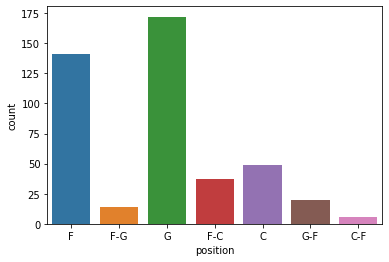

In [11]:
print(np.unique(df.position, return_counts=True))
sns.countplot(x='position', data=df);

Количество "Пограничных" меток (когда игрок может играть в двух позициях) слишком низкое - приведем к первой позиции в паре.

(array(['C', 'F', 'G'], dtype=object), array([ 55, 192, 192], dtype=int64))


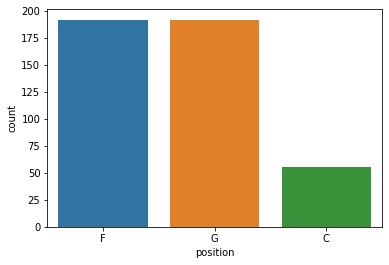

In [12]:
df['position'] = df['position'].replace('F-G', 'F')
df['position'] = df['position'].replace('F-C', 'F')
df['position'] = df['position'].replace('G-F', 'G')
df['position'] = df['position'].replace('C-F', 'C')
print(np.unique(df.position, return_counts=True))
sns.countplot(x='position', data=df);

## Корреляция признаков

Проверим признаки на их попарную корреляцию

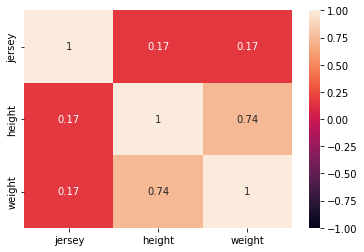

In [13]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

## Декомпозиция
Опишем имеющиеся данные в пространстве меньшей размерности. Воспользуемся алгоритмом PCA (Principal component analysis) 

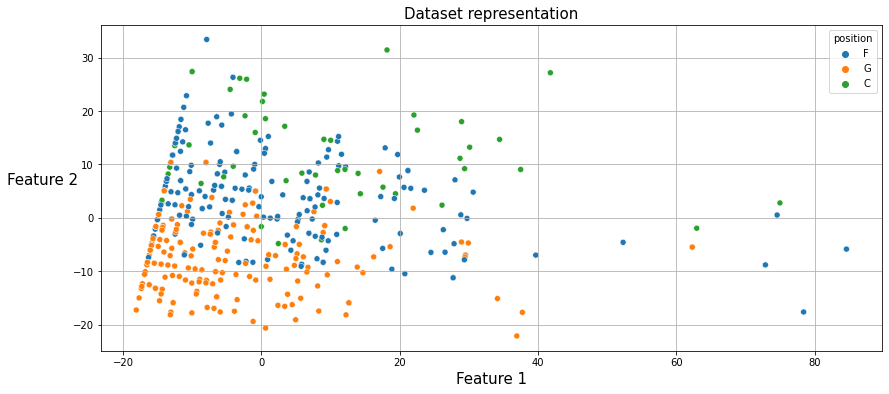

In [14]:
from sklearn.decomposition import PCA

X_embedded = PCA(n_components=2, random_state=993).fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

ax.set_title('Dataset representation', fontsize=15)
ax.set_xlabel('Feature 1', fontsize=15)
ax.set_ylabel('Feature 2', rotation=0, labelpad=30, fontsize=15)
ax.grid()

sns.scatterplot(
    x=X_embedded[:, 0], 
    y=X_embedded[:, 1], 
    hue=df.position,
    ax=ax
);

Рассмотрим попарные представления данных и гистограммы для одиночных признаков

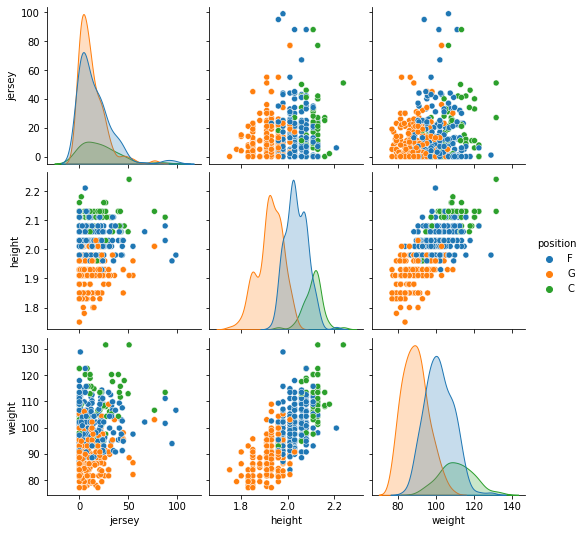

In [15]:
sns.pairplot(df, hue='position');

## Алгоритмы классификации
Обучим алгоритм Forest и оценим качество его работы.

In [16]:
forest_clf = RandomForestClassifier()

forest_acc_score = cross_val_score(forest_clf, X, y, scoring='f1_micro').mean()

print('Forest: ', forest_acc_score)


Forest:  0.8154911180773249


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2)

forest_clf = RandomForestClassifier()

forest_clf.fit(X_train, y_train)

forest_pred = forest_clf.predict(X_test)

forest_prec_score = f1_score(y_test, forest_pred, average='micro')

print('Forest: ', forest_prec_score)

Forest:  0.875
